# UTS PSD

## Preparation

### Load Library

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import BaggingRegressor
from joblib import dump, load

### Load Data

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/Rieko00/psd/main/bmri_uni.csv')
df

,Tanggal,Pembukaan
0,11/10/2024,7025
1,10/10/2024,6925
2,09/10/2024,7075
3,08/10/2024,6825
4,07/10/2024,6925
...,...,...
1398,08/01/2019,7425
1399,07/01/2019,7500
1400,04/01/2019,7175
1401,03/01/2019,7275


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403 entries, 0 to 1402
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tanggal    1403 non-null   object
 1   Pembukaan  1403 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 22.1+ KB


### Change Dtypes

In [4]:
df = df[['Tanggal', 'Pembukaan']]
df['Tanggal'] = pd.to_datetime(df['Tanggal'], dayfirst=True, format='%d/%m/%Y').dt.date
df.set_index('Tanggal', inplace=True)
df.index = pd.to_datetime(df.index)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

### Plot Data

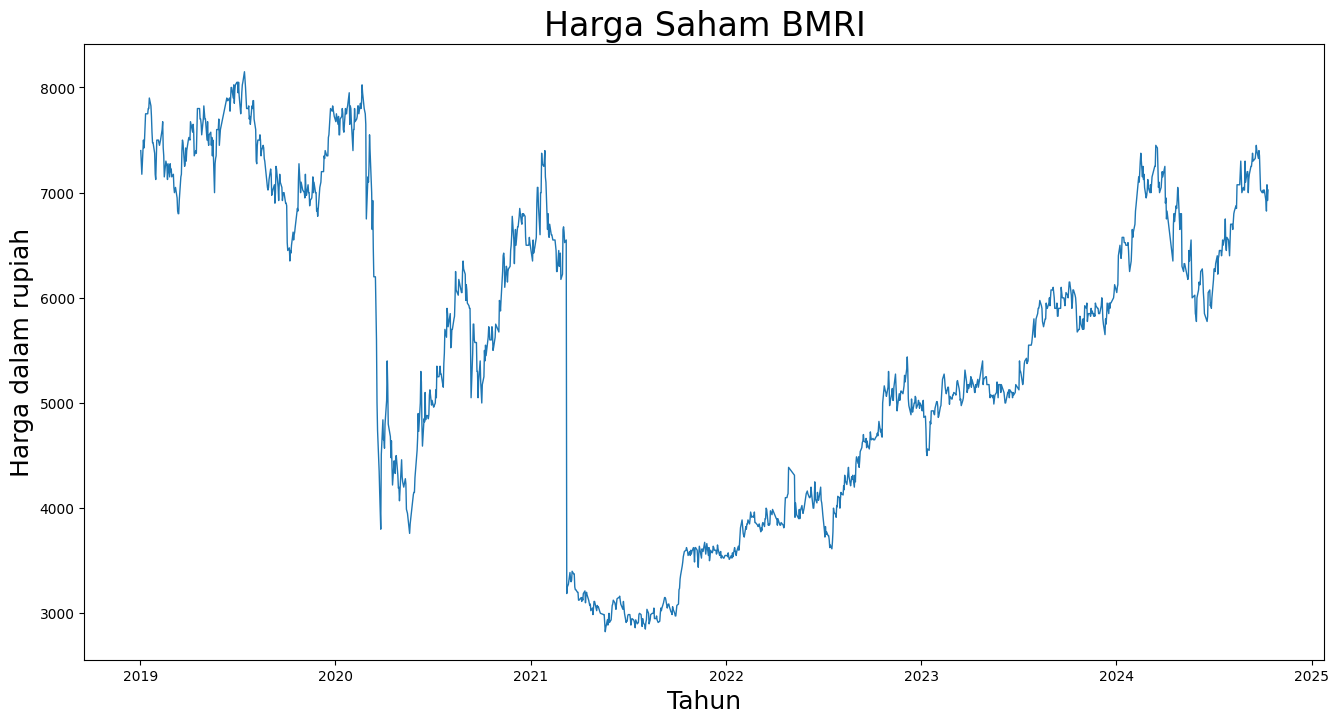

In [5]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham BMRI", fontsize=24)
plt.ylabel('Harga dalam rupiah', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#2419ef", "#19c4ef", "#EF5919"])
sns.lineplot(x='Tanggal', y='Pembukaan', data=df, linewidth=1.0, dashes=False, ax=ax1)
plt.show()

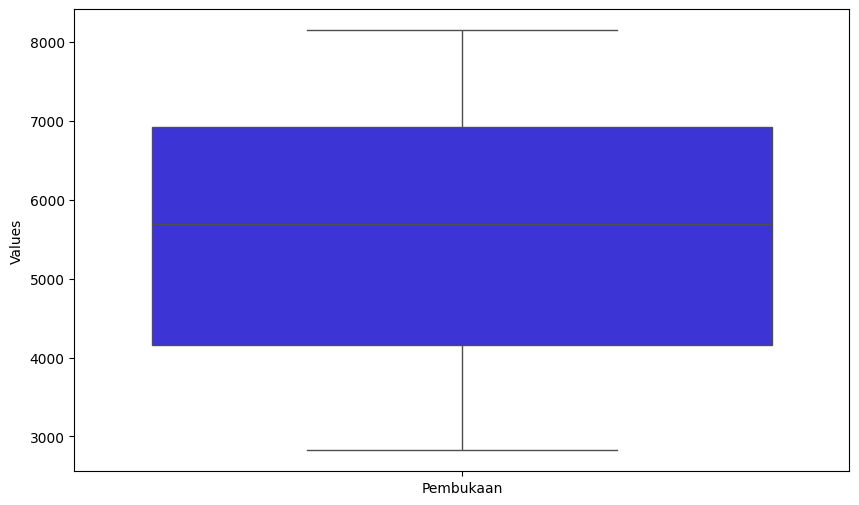

In [6]:
features = ['Pembukaan']
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[features])
plt.ylabel('Values')
plt.show()

## Prepocessing

### Data Normalization

In [7]:
scaler = MinMaxScaler()
df['Pembukaan'] = scaler.fit_transform(df[['Pembukaan']])

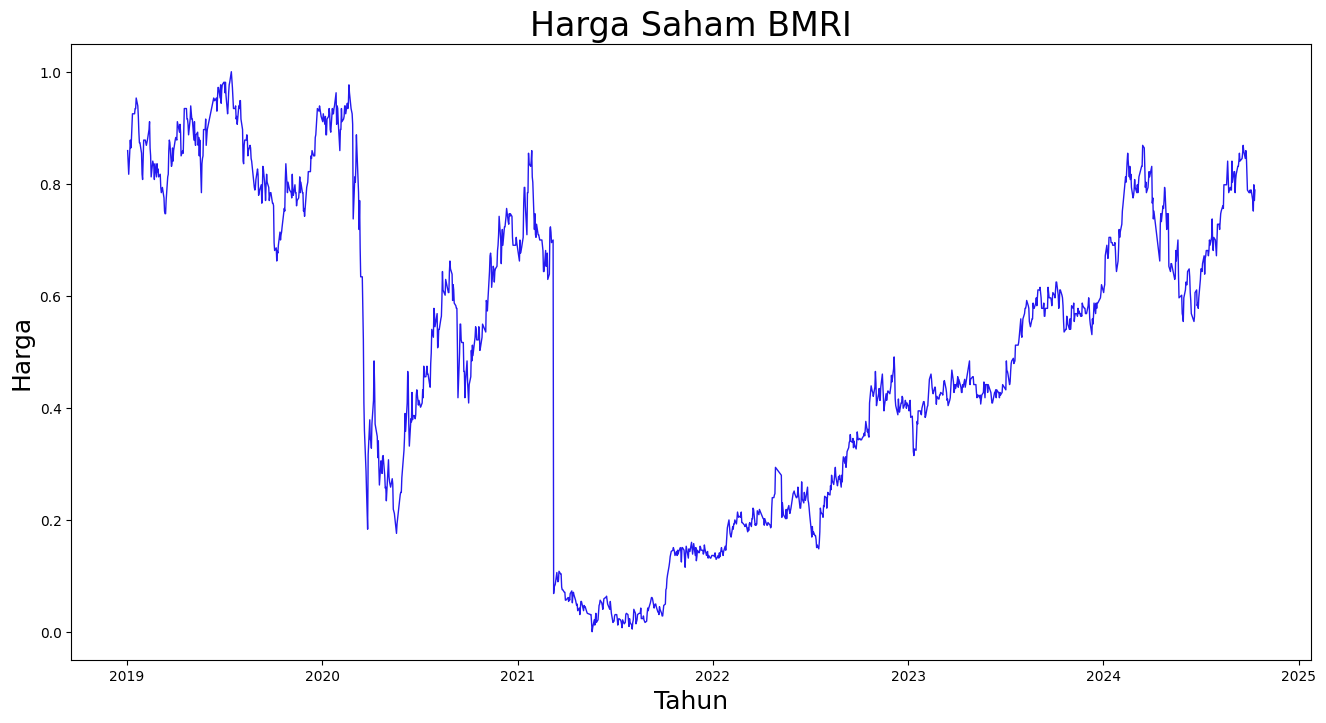

In [8]:
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("Harga Saham BMRI", fontsize=24)
plt.ylabel('Harga', fontsize=18)
plt.xlabel('Tahun', fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(x='Tanggal', y='Pembukaan', data=df, linewidth=1.0, dashes=False, ax=ax1)
plt.show()

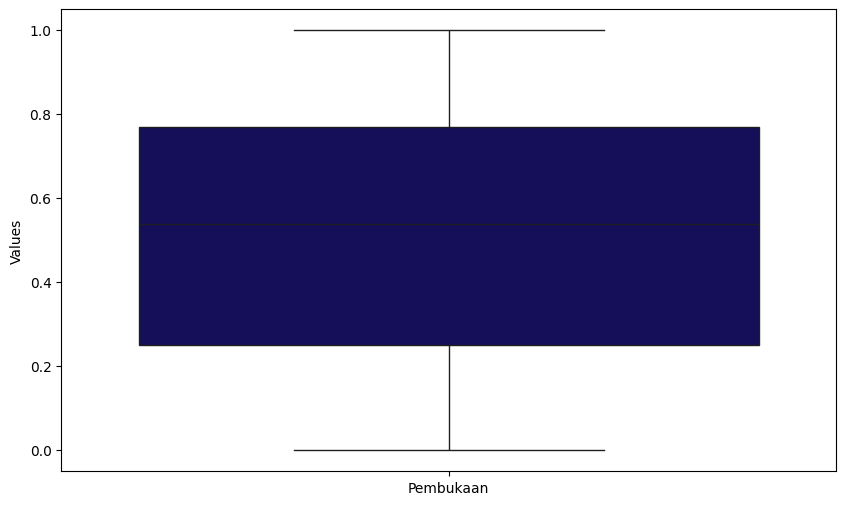

In [9]:
features = ['Pembukaan']
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[features])
plt.ylabel('Values')
plt.show()

In [10]:
df

,Pembukaan
Tanggal,
2019-01-02,0.859155
2019-01-03,0.835681
2019-01-04,0.816901
2019-01-07,0.877934
2019-01-08,0.863850
...,...
2024-10-07,0.769953
2024-10-08,0.751174
2024-10-09,0.798122


### Sliding Window

In [11]:
def sliding_window(data, lag):
    series = data['Pembukaan']
    result = pd.DataFrame()
    for l in lag:
        result[f'open-{l}'] = series.shift(l)

    result['open'] = series[l:]
    result = result.dropna()
    result.index = series.index[l:]
    return result

windowed_data = sliding_window(df, [1, 2, 3])
windowed_data = windowed_data[['open', 'open-1', 'open-2', 'open-3']]
print(windowed_data)

                open    open-1    open-2    open-3
Tanggal                                           
2019-01-07  0.877934  0.816901  0.835681  0.859155
2019-01-08  0.863850  0.877934  0.816901  0.835681
2019-01-09  0.877934  0.863850  0.877934  0.816901
2019-01-10  0.901408  0.877934  0.863850  0.877934
2019-01-11  0.924883  0.901408  0.877934  0.863850
...              ...       ...       ...       ...
2024-10-07  0.769953  0.788732  0.784038  0.788732
2024-10-08  0.751174  0.769953  0.788732  0.784038
2024-10-09  0.798122  0.751174  0.769953  0.788732
2024-10-10  0.769953  0.798122  0.751174  0.769953
2024-10-11  0.788732  0.769953  0.798122  0.751174

[1400 rows x 4 columns]


### Split Data

In [12]:
def split_data(data, target, train_size):
    split_index = int(len(data) * train_size)

    x_train = data[:split_index]
    y_train = target[:split_index]
    x_test = data[split_index:]
    y_test = target[split_index:]

    return x_train, y_train, x_test, y_test

input_df = windowed_data[['open-1', 'open-2', 'open-3']]
target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, 0.8)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1120, 3)
y_train shape: (1120, 1)
X_test shape: (280, 3)
y_test shape: (280, 1)


## Modelling

Pengukuran Akurasi

$MSE = mean((predicted - actual)^2)$

$RMSE = sqrt(mean((predicted - actual)^2))$

$MAPE = 100 * mean(abs((predicted - actual) / actual))$





### Bagging Linear Regression

In [13]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)

y_pred = linear_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 0.00045230041247564266
Root Mean Squared Error (RMSE): 0.021267355559063818
Mean Absolute Percentage Error (MAPE): 2.341169293979738 %


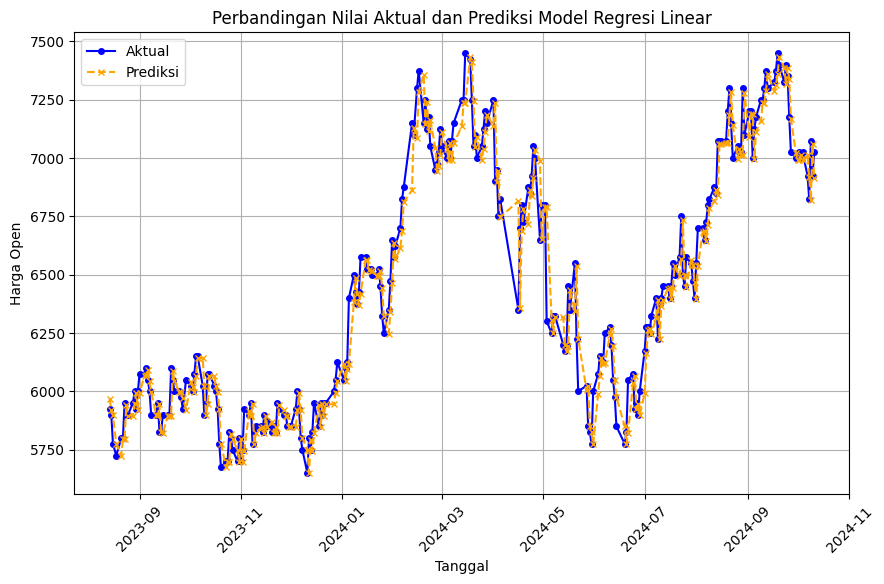

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [15]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = linear_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6916.001383650782 (-1.55%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [16]:
base_model = LinearRegression()
bagging_model = BaggingRegressor(estimator=base_model, n_estimators=10, bootstrap=True)
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

Mean Squared Error: 0.0004519893721712153
Root Mean Squared Error: 0.02126004167849196
Mean Absolute Percentage Error (MAPE): 2.3416603799921063 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


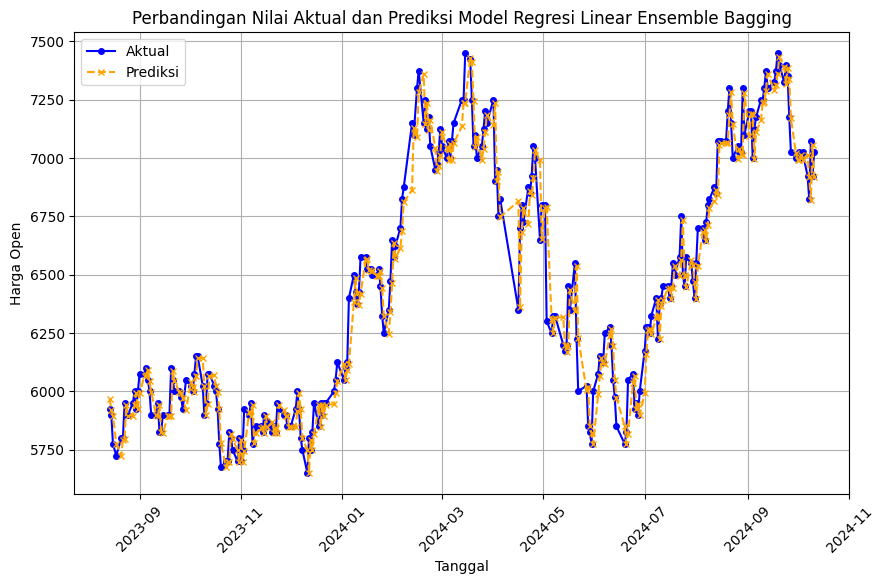

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear Ensemble Bagging')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [18]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = bagging_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))
last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100
if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6919.0585870686455 (-1.51%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


### Grid Search Linear Bagging Regressor

In [91]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search(input_df, target_df, splits, lags, estimators, bootstraps, max_samples):
    best_rmse = float('inf')
    best_params = None
    history = []
    i = 1
    for lag_value in lags:
        lag = [i for i in range(1, lag_value+1)]  
        windowed_data = sliding_window(df, lag)
        windowed_data = windowed_data[['open'] + [f'open-{i}' for i in range(1, lag_value+1)]]
        input_df = windowed_data[[f'open-{i}' for i in range(1, lag_value+1)]]
        target_df = windowed_data[['open']]
        for split in splits:
            x_train, y_train, x_test, y_test = split_data(input_df, target_df, split)
            for estimator in estimators:
                for bootstrap in bootstraps:
                    for max_sample in max_samples:
                        base_model = LinearRegression()
                        bagging_model = BaggingRegressor(estimator=base_model, n_estimators=estimator, bootstrap=bootstrap, max_samples=max_sample)
                        bagging_model.fit(x_train, y_train.values.ravel())
                        y_pred = bagging_model.predict(x_test)
                        current_rmse = rmse(y_test, y_pred)
                        history.append([i,lag_value,split,estimator,bootstrap,max_sample,current_rmse])
                        i+=1
                        if current_rmse < best_rmse:
                            best_rmse = current_rmse
                            best_model = bagging_model
                            best_params = {'estimator': estimator, 'bootstrap': bootstrap, 'train_sample': split, 'max_sample': max_sample, 'lag': lag}
    linear_history = pd.DataFrame(history, columns=['Iterasi','Lag','Split','Estimator','Bootstrap','Max Sample','RMSE'])
    return best_params, best_rmse, best_model, linear_history

lag = [3, 4, 5]
splits = [0.7, 0.75, 0.8, 0.85, 0.9]
estimators = [10, 20, 50, 100]
bootstraps = [True, False]
max_samples = [0.8, 0.9, 1.0]

best_params, best_rmse, best_model_linear, history_linear = grid_search(input_df, target_df, splits, lag , estimators, bootstraps, max_samples)




In [92]:
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best Model: {best_model_linear}')


Best parameters: {'estimator': 10, 'bootstrap': True, 'train_sample': 0.7, 'max_sample': 1.0, 'lag': [1, 2, 3, 4]}
Best RMSE: 0.019310234242848136
Best Model: BaggingRegressor(estimator=LinearRegression())


In [93]:
dump(best_model_linear, 'model_linear.pkl')

['model_linear.pkl']

In [94]:
history_linear.to_excel('linear_history.xlsx', index=False)

In [ ]:
for lag_value in best_params['lag']:
    lag = [i for i in range(1, lag_value+1)]  
    windowed_data = sliding_window(df, lag)
    windowed_data = windowed_data[['open'] + [f'open-{i}' for i in range(1, lag_value+1)]]
    input_df = windowed_data[[f'open-{i}' for i in range(1, lag_value+1)]]
    target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, best_params['train_sample'])

bagging_model = best_model
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

Mean Squared Error: 0.0003762757065801323
Root Mean Squared Error: 0.019397827367520628
Mean Absolute Percentage Error (MAPE): 2.416618112966434 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


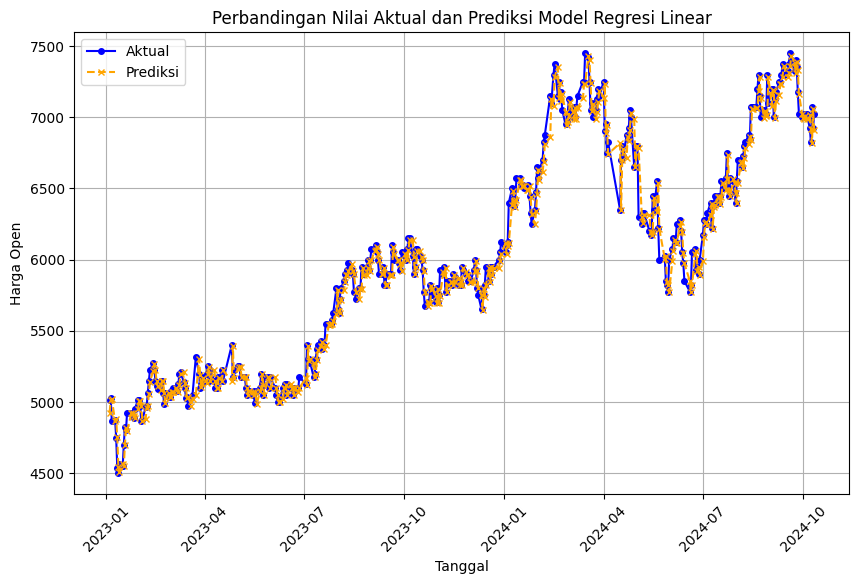

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Bagging SVM

In [37]:
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor

svm_model = SVR()
svm_model.fit(x_train, y_train)

y_pred = svm_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 0.0010771866578538102
Root Mean Squared Error (RMSE): 0.032820521900996796
Mean Absolute Percentage Error (MAPE): 4.212439435355245 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


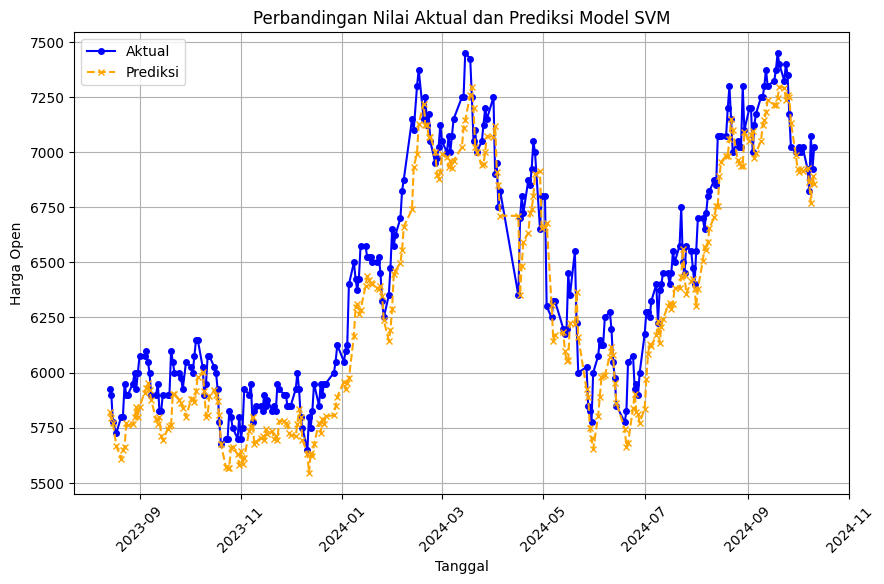

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model SVM')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = svm_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6856.750398555171 (-2.40%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [ ]:
base_model = SVR()
bagging_model = BaggingRegressor(estimator=base_model, n_estimators=50, bootstrap=True, random_state=42)
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Mean Squared Error: 0.001350347565019255
Root Mean Squared Error: 0.03674707559819223
Mean Absolute Percentage Error (MAPE): 4.826791117208925 %


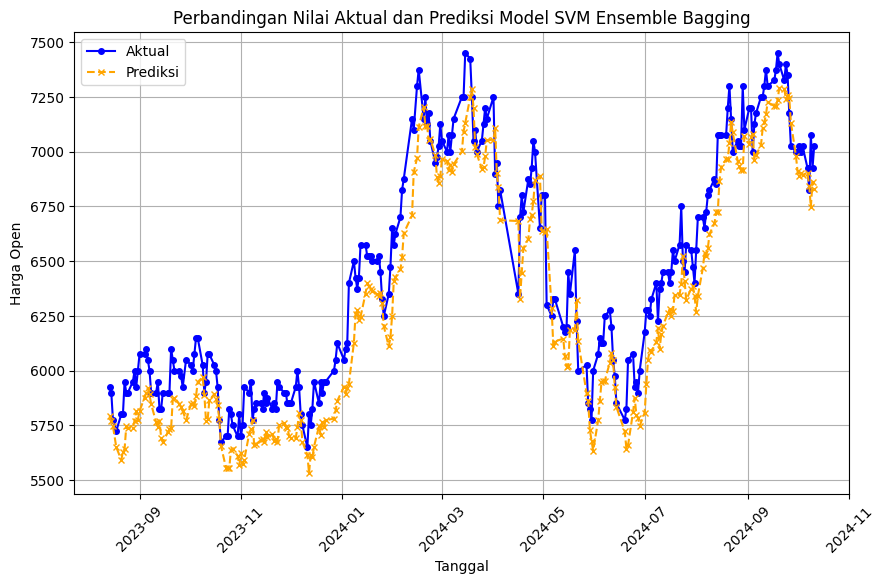

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model SVM Ensemble Bagging')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [ ]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = bagging_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6830.980449593076 (-2.76%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but BaggingRegressor was fitted with feature names
  warnings.warn(


### Grid Search SVM Bagging Regressor

In [41]:
def EnsembleSVR(x_train, y_train, C, gamma, epsilon, kernel, degree, n_estimators):
  # Initialize the SVR model
  if kernel == 'poly':
    svr = SVR(C=C, gamma=gamma, epsilon=epsilon, kernel=kernel, degree=degree)
    ensemble_svr = BaggingRegressor(estimator=svr, n_estimators=n_estimators, random_state=0)
  else:
    svr = SVR(C=C, gamma=gamma, epsilon=epsilon, kernel=kernel)
    ensemble_svr = BaggingRegressor(estimator=svr, n_estimators=n_estimators, random_state=0)

  # Melatih model
  ensemble_svr.fit(x_train, y_train.values.ravel())

  return ensemble_svr


In [95]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search_SVM(input_df, target_df, params):
    best_rmse = float('inf')
    best_params = None
    history = []
    i = 1
    for lag_value in params['lags']:
        lag = [i for i in range(1, lag_value+1)]  
        windowed_data = sliding_window(df, lag)
        windowed_data = windowed_data[['open'] + [f'open-{i}' for i in range(1, lag_value+1)]]
        input_df = windowed_data[[f'open-{i}' for i in range(1, lag_value+1)]]
        target_df = windowed_data[['open']]
        for split in params['splits']:
            x_train, y_train, x_test, y_test = split_data(input_df, target_df, split)
            for C in params['C']:
                for gamma in params['gamma']:
                    for kernel in params['kernel']:
                    # Jika kernel adalah 'poly', iterasi melalui 'degree', jika tidak hanya gunakan None
                        if kernel == 'poly':
                            degrees = params['degree']
                        else:
                            degrees = [np.nan]
                        for degree in degrees:
                            for n_estimators in params['n_estimators']:
                                for epsilon in params['epsilon']:
                                    model = EnsembleSVR(x_train, y_train, C, gamma, epsilon, kernel, degree, n_estimators)
                                    y_pred = model.predict(x_test)
                                    current_rmse = rmse(y_test, y_pred)
                                    history.append([lag_value, split, i, C, gamma, epsilon, kernel, degree, n_estimators, current_rmse])
                                    print(f'Iterasi ke-{i} | RMSE: {current_rmse}, Lag: {lag_value}, Split: {split}, C: {C}, gamma: {gamma}, epsilon: {epsilon}, kernel: {kernel}, degree: {degree}, n_estimators: {n_estimators}')
                                    i += 1
                                    if current_rmse < best_rmse:
                                        best_rmse = current_rmse
                                        best_model = model
                                        best_params = {'lag': lag_value, 'split': split, 'C': C, 'gamma': gamma, 'epsilon': epsilon, 'kernel': kernel, 'degree': degree, 'n_estimators': n_estimators}
    svm_history = pd.DataFrame(history, columns=['lag','split', 'Iterasi', 'C', 'gamma', 'epsilon', 'kernel', 'degree', 'n_estimators', 'RMSE'])
    return best_params, best_rmse, best_model, svm_history

parameter = {
    'lags' : [3, 5],
    'splits' : [0.7, 0.8, 0.9],
    'C':[1,100],
    'gamma':[0.1,0.5],
    'epsilon':[0.01,0.1],
    'kernel':['linear', 'rbf'],
    'n_estimators':[50, 100]
}


best_params, best_rmse, best_model, svm_history = grid_search_SVM(input_df, target_df, parameter)




Iterasi ke-1 | RMSE: 0.019193813692011133, Lag: 3, Split: 0.7, C: 1, gamma: 0.1, epsilon: 0.01, kernel: linear, degree: nan, n_estimators: 50
Iterasi ke-2 | RMSE: 0.029567148356953826, Lag: 3, Split: 0.7, C: 1, gamma: 0.1, epsilon: 0.1, kernel: linear, degree: nan, n_estimators: 50
Iterasi ke-3 | RMSE: 0.019196419320134526, Lag: 3, Split: 0.7, C: 1, gamma: 0.1, epsilon: 0.01, kernel: linear, degree: nan, n_estimators: 100
Iterasi ke-4 | RMSE: 0.02963800079342043, Lag: 3, Split: 0.7, C: 1, gamma: 0.1, epsilon: 0.1, kernel: linear, degree: nan, n_estimators: 100
Iterasi ke-5 | RMSE: 0.01975286389481638, Lag: 3, Split: 0.7, C: 1, gamma: 0.1, epsilon: 0.01, kernel: rbf, degree: nan, n_estimators: 50
Iterasi ke-6 | RMSE: 0.03358350873440678, Lag: 3, Split: 0.7, C: 1, gamma: 0.1, epsilon: 0.1, kernel: rbf, degree: nan, n_estimators: 50
Iterasi ke-7 | RMSE: 0.019701903746086644, Lag: 3, Split: 0.7, C: 1, gamma: 0.1, epsilon: 0.01, kernel: rbf, degree: nan, n_estimators: 100
Iterasi ke-8 | RMS

In [96]:
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best Model: {best_model}')

Best parameters: {'lag': 3, 'split': 0.7, 'C': 100, 'gamma': 0.1, 'epsilon': 0.01, 'kernel': 'rbf', 'degree': nan, 'n_estimators': 100}
Best RMSE: 0.01916633621076888
Best Model: BaggingRegressor(estimator=SVR(C=100, epsilon=0.01, gamma=0.1),
                 n_estimators=100, random_state=0)


In [97]:
dump(best_model, 'model_SVM.pkl')

['model_SVM.pkl']

In [98]:
svm_history.to_excel('svm_history.xlsx', index=False)

### Bagging Tree

In [76]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

tree_model = DecisionTreeRegressor()
tree_model.fit(x_train, y_train)

y_pred = tree_model.predict(x_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape,"%")

Mean Squared Error (MSE): 0.0013502769354782841
Root Mean Squared Error (RMSE): 0.03674611456301583
Mean Absolute Percentage Error (MAPE): 4.177658760888094 %


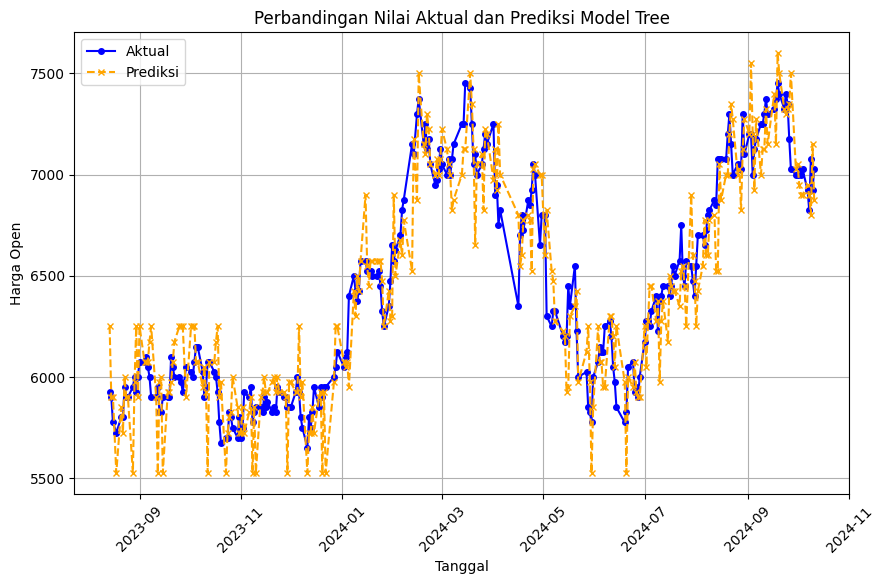

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Tree')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [78]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = tree_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 6875.0 (-2.14%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [79]:
from sklearn.ensemble import RandomForestRegressor
bagging_model = RandomForestRegressor(n_estimators=100, random_state=42)
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

Mean Squared Error: 0.0006740723047770221
Root Mean Squared Error: 0.025962902472123992
Mean Absolute Percentage Error (MAPE): 2.922853646340517 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


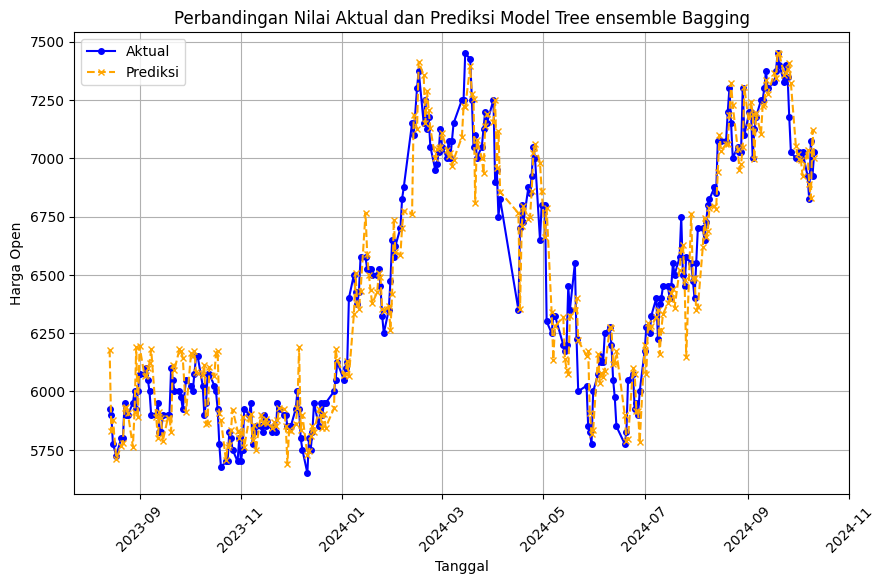

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Tree ensemble Bagging')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

In [81]:
last_row = windowed_data.iloc[-1][['open-1', 'open-2', 'open-3']].values.reshape(1, -1)
predicted_value_normalized = bagging_model.predict(last_row)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))

last_price = scaler.inverse_transform(df[['Pembukaan']].iloc[-1].values.reshape(-1, 1))
percentage_change = ((predicted_value[0][0] - last_price[0][0]) / last_price[0][0]) * 100

if percentage_change > 0:
    change_sign = '+'
else:
    change_sign = ''

print(f'Harga BMRI Hari ini: {last_price[0][0]}')
print(f'Prediksi Harga BMRI Besok: {predicted_value[0][0]} ({change_sign}{percentage_change:.2f}%)')

Harga BMRI Hari ini: 7025.0
Prediksi Harga BMRI Besok: 7002.75 (-0.32%)


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Grid Search Bagging Tree

In [87]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search_rf(input_df, target_df, params):
    best_rmse = float('inf')
    best_params = None
    history = []
    i = 0
    for lag_value in params['lags']:
        lag = [i for i in range(1, lag_value+1)]  
        windowed_data = sliding_window(df, lag)
        windowed_data = windowed_data[['open'] + [f'open-{i}' for i in range(1, lag_value+1)]]
        input_df = windowed_data[[f'open-{i}' for i in range(1, lag_value+1)]]
        target_df = windowed_data[['open']]
        for split in params['splits']:
            x_train, y_train, x_test, y_test = split_data(input_df, target_df, split)
            for estimator in params['n_estimators']:
                for criterion in params['criterion']:
                    for max_depth in params['max_depth']:
                        for min_samples_split in params['min_samples_split']:
                            for min_samples_leaf in params['min_samples_leaf']:
                                for max_features in params['max_features']:
                                    model = RandomForestRegressor(n_estimators=estimator, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
                                    model.fit(x_train, y_train.values.ravel())
                                    y_pred = model.predict(x_test)
                                    current_rmse = rmse(y_test, y_pred)
                                    print(f'Iterasi ke-{i} - RMSE: {current_rmse} - n_estimators: {estimator} - criterion: {criterion} - max_depth: {max_depth} - min_samples_split: {min_samples_split} - min_samples_leaf: {min_samples_leaf} - max_features: {max_features}')
                                    history.append([i, lag_value, split, estimator, criterion, max_depth, min_samples_split, min_samples_leaf, max_features, current_rmse])
                                    i+=1
                                    if current_rmse < best_rmse:
                                        best_rmse = current_rmse
                                        best_model = model
                                        best_params = {'estimator': estimator, 'criterion': criterion, 'train_sample': split, 'max_depth': max_depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'max_features': max_features, 'lag': lag}

    history_rf = pd.DataFrame(history, columns=['Iterasi', 'Lag', 'Split', 'Estimator', 'Criterion', 'Max Depth', 'Min Samples Split', 'Min Samples Leaf', 'Max Features', 'RMSE'])
    return best_params, best_rmse, best_model, history_rf


estimators = [10, 20, 50, 100]
bootstraps = [True, False]
max_samples = [0.8, 0.9, 1.0]

parameters = {
    'lags' : [3, 4, 5],
    'splits' : [0.7, 0.8, 0.9],
    'n_estimators': [100, 200, 500],
    'criterion' : ['squared_error', 'absolute_error', 'friedman_mse', 'poisson'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

parameters = {
    'lags' : [3, 5],
    'splits' : [0.7, 0.8, 0.9],
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['squared_error', 'absolute_error']
}


best_params, best_rmse, best_model_rf, history_rf = grid_search_rf(input_df, target_df, parameters)



Iterasi ke-0 - RMSE: 0.02525016355635015 - n_estimators: 50 - criterion: squared_error - max_depth: 5 - min_samples_split: 2 - min_samples_leaf: 1 - max_features: sqrt
Iterasi ke-1 - RMSE: 0.02525016355635015 - n_estimators: 50 - criterion: squared_error - max_depth: 5 - min_samples_split: 2 - min_samples_leaf: 1 - max_features: log2
Iterasi ke-2 - RMSE: 0.02477284958472541 - n_estimators: 50 - criterion: squared_error - max_depth: 5 - min_samples_split: 2 - min_samples_leaf: 2 - max_features: sqrt
Iterasi ke-3 - RMSE: 0.02477284958472541 - n_estimators: 50 - criterion: squared_error - max_depth: 5 - min_samples_split: 2 - min_samples_leaf: 2 - max_features: log2
Iterasi ke-4 - RMSE: 0.02522643587398921 - n_estimators: 50 - criterion: squared_error - max_depth: 5 - min_samples_split: 5 - min_samples_leaf: 1 - max_features: sqrt
Iterasi ke-5 - RMSE: 0.02522643587398921 - n_estimators: 50 - criterion: squared_error - max_depth: 5 - min_samples_split: 5 - min_samples_leaf: 1 - max_feature

In [88]:
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best Model: {best_model_rf}')

Best parameters: {'estimator': 50, 'criterion': 'absolute_error', 'train_sample': 0.7, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'lag': [1, 2, 3]}
Best RMSE: 0.021881715140692114
Best Model: RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features='sqrt', min_samples_leaf=2, n_estimators=50,
                      random_state=42)


In [89]:
dump(best_model_rf, 'model_tree.pkl')

['model_tree.pkl']

In [90]:
history_rf.to_excel('rf_history.xlsx', index=False)

## Evaluasi

### Grid Search

In [46]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search(input_df, target_df, splits, lags, estimators, bootstraps, max_samples):
    best_rmse = float('inf')
    best_params = None
    graph = pd.DataFrame()
    i = 0
    for lag_value in lags:
        lag = [i for i in range(1, lag_value+1)]  
        windowed_data = sliding_window(df, lag)
        windowed_data = windowed_data[['open'] + [f'open-{i}' for i in range(1, lag_value+1)]]
        input_df = windowed_data[[f'open-{i}' for i in range(1, lag_value+1)]]
        target_df = windowed_data[['open']]
        for split in splits:
            x_train, y_train, x_test, y_test = split_data(input_df, target_df, split)
            for estimator in estimators:
                for bootstrap in bootstraps:
                    for max_sample in max_samples:
                        base_model = LinearRegression()
                        bagging_model = BaggingRegressor(estimator=base_model, n_estimators=estimator, bootstrap=bootstrap, max_samples=max_sample)
                        bagging_model.fit(x_train, y_train.values.ravel())
                        y_pred = bagging_model.predict(x_test)
                        i+=1
                        current_rmse = rmse(y_test, y_pred)
                        if current_rmse < best_rmse:
                            best_rmse = current_rmse
                            best_model = bagging_model
                            best_params = {'estimator': estimator, 'bootstrap': bootstrap, 'train_sample': split, 'max_sample': max_sample, 'lag': lag}
    return best_params, best_rmse, best_model

lag = [3, 4, 5]
splits = [0.7, 0.75, 0.8, 0.85, 0.9]
estimators = [10, 20, 50, 100]
bootstraps = [True, False]
max_samples = [0.8, 0.9, 1.0]

best_params, best_rmse, best_model = grid_search(input_df, target_df, splits, lag , estimators, bootstraps, max_samples)



In [ ]:
print(f'Best parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print(f'Best Model: {best_model}')

Best parameters: {'estimator': 10, 'bootstrap': True, 'train_sample': 0.7, 'max_sample': 1.0, 'lag': [1, 2, 3]}
Best RMSE: 0.01930790745620675
Best Model: BaggingRegressor(estimator=LinearRegression())


In [ ]:
for lag_value in best_params['lag']:
    lag = [i for i in range(1, lag_value+1)]  
    windowed_data = sliding_window(df, lag)
    windowed_data = windowed_data[['open'] + [f'open-{i}' for i in range(1, lag_value+1)]]
    input_df = windowed_data[[f'open-{i}' for i in range(1, lag_value+1)]]
    target_df = windowed_data[['open']]

x_train, y_train, x_test, y_test = split_data(input_df, target_df, best_params['train_sample'])

bagging_model = best_model
bagging_model.fit(x_train, y_train)
y_pred = bagging_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print("Mean Absolute Percentage Error (MAPE):", mape ,"%")

Mean Squared Error: 0.0003756400034722916
Root Mean Squared Error: 0.01938143450501772
Mean Absolute Percentage Error (MAPE): 2.4154870691940866 %


c:\Users\ariek\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


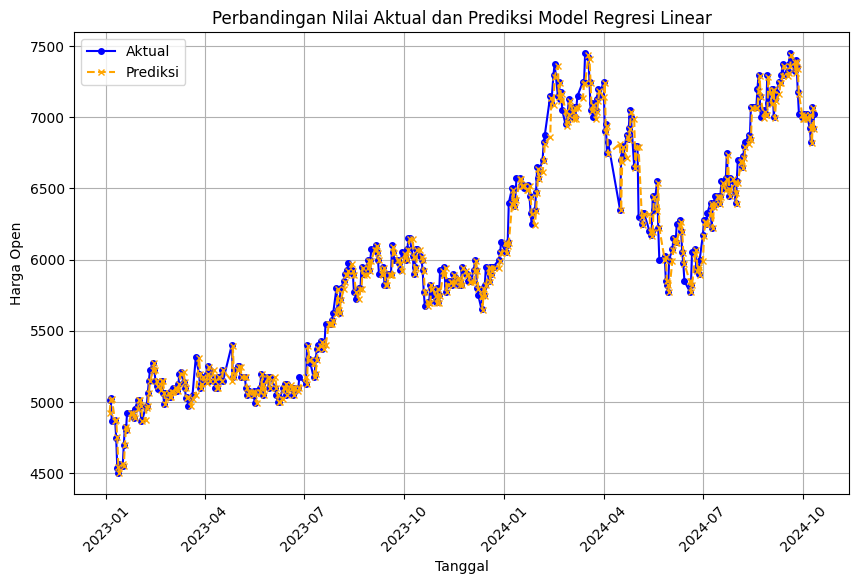

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, scaler.inverse_transform(y_test.values.reshape(-1, 1)), label='Aktual', color='blue', marker='o', linestyle='-', markersize=4)
plt.plot(y_test.index, scaler.inverse_transform(y_pred.reshape(-1, 1)), label='Prediksi', color='orange', marker='x', linestyle='--', markersize=4)
plt.title('Perbandingan Nilai Aktual dan Prediksi Model Regresi Linear')
plt.xlabel('Tanggal')
plt.ylabel('Harga Open')
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.show()

### Testing Model

In [ ]:
# open_1 = int(input("Harga BMRI hari ini: "))
# open_2 = int(input("Harga BMRI 1 hari sebelumnya: "))
# open_3 = int(input("Harga BMRI 2 hari sebelumnya: "))

open_values = {}
for i in best_params['lag']:
    open_values[f'open_{i}'] = int(input(f"Harga BMRI {i} hari sebelumnya: "))

last_row = np.array([
    scaler.transform([[open_values[f'open_{i}']]]).flatten()[0] for i in best_params['lag']
]).reshape(1, -1)

last_row_df = pd.DataFrame(last_row, columns=[f'open-{i}' for i in best_params['lag']])
predicted_value_normalized = best_model.predict(last_row_df)
predicted_value = scaler.inverse_transform(predicted_value_normalized.reshape(-1, 1))
last_price = open_values['open_1']
percentage_change = ((predicted_value[0][0] - last_price) / last_price) * 100
change_sign = '+' if percentage_change > 0 else ''

formatted_predicted_value = f"{predicted_value[0][0]:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')
formatted_last_price = f"{last_price:,.2f}".replace(',', 'X').replace('.', ',').replace('X', '.')

print(f'Harga BMRI Hari ini: Rp {formatted_last_price}')
print(f'Prediksi harga BMRI Besok: Rp {formatted_predicted_value} ({change_sign}{percentage_change:.2f}%)')

ValueError: invalid literal for int() with base 10: ''